In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
print("Is GPU available?", tf.test.is_gpu_available())
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? True
TF version: 2.3.1
Keras version: 2.4.0


In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [3]:
class NN(Model):
    def __init__(self, n_actions, input_shape):
        super(NN, self).__init__()
        
        self.dense1 = Dense(256, activation='relu', input_shape = (*input_shape,))
        self.dense2 = Dense(256, activation='relu')
        self.V = Dense(1, activation=None)
        self.A = Dense(n_actions, activation=None)
    
    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        
        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))
        
        return Q
    
    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        A = self.A(x)
        
        return A

In [4]:
class Agent():
    def __init__(self, input_shape, n_actions, mem_size, eps, eps_min, eps_dec, gamma, q_eval_name, q_next_name, 
                 replace_freq, lr=0.0005):
        self.Q_eval = NN(n_actions, input_shape)
        self.Q_next = NN(n_actions, input_shape)
        self.Q_eval.compile(optimizer=Adam(lr=lr), loss='mse')
        self.Q_next.compile(optimizer=Adam(lr=lr), loss='mse')
        self.memory = deque(maxlen=mem_size)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.gamma = gamma
        self.replace = replace_freq
        self.action_space = [i for i in range(n_actions)]
        self.steps = 0
        self.input_shape = input_shape
        self.q_eval_name = q_eval_name
        self.q_next_name = q_next_name
    
    def store(self, state, action, reward, n_state, done):
        pack = [np.expand_dims(state, axis=0), action, reward, np.expand_dims(n_state, axis=0), done]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
        return states, actions, rewards, n_states, dones
    
    def choose_action(self, state):
        if np.random.random() > self.eps:
            return np.argmax(self.Q_eval.advantage(state))
        return np.random.choice(self.action_space)
    
    def decay_eps(self): 
        self.eps = self.eps - self.eps_dec if self.eps > self.eps_min else self.eps_min
    
    def replace_weights(self):
        if not (self.steps % self.replace):
            self.Q_next.set_weights(self.Q_eval.get_weights())
    
    def upgrade(self, batch_size=64):
        if len(self.memory) >= 4*batch_size:
            states, actions, rewards, n_states, dones = self.take_data(batch_size)
            
            self.replace_weights()
            
            act = [np.argmax(self.Q_eval(np.array(n_states[i]))) for i in range(batch_size)]
            q_next = [self.Q_next(np.array(n_states[i])).numpy()[0][act[i]] for i in range(batch_size)]
            q_target = [self.Q_eval(states[i]).numpy()[0] for i in range(batch_size)]
            
            for i in range(batch_size):
                q_target[i][actions[i]] = rewards[i] + self.gamma*q_next[i]*(1 - dones[i])
            
            states = np.reshape(states, (batch_size, *self.input_shape))
            
            self.Q_eval.train_on_batch(np.array(states), np.array(q_target))
            
            self.decay_eps()
            self.steps += 1

    def save(self):
        self.Q_eval.save_weights(self.q_eval_name)
        

In [5]:
env = gym.make('Acrobot-v1')
n_games = 500
agent = Agent(input_shape=env.observation_space.shape, n_actions=env.action_space.n, mem_size=10000, eps=1.0, 
              eps_min=0.001, eps_dec=0.001, gamma=0.99, q_eval_name='Q_eval.h5', q_next_name='Q_next.h5', 
              replace_freq=500)
best_score = -500
scores = []
means = []
eps = []

for i in range(n_games):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(np.expand_dims(state, axis=0))
        n_state, reward, done, _ = env.step(action)
        score += reward
        agent.store(state, action, reward, n_state, int(done))
        state = n_state
        agent.upgrade()
    scores.append(score)
    mean = np.mean(scores[-20:])
    means.append(mean)
    eps.append(agent.eps)
    if mean > best_score:
        agent.save()
        best_score = mean
    print('episode: ', i+1, '   score: ', score, '   eps:  %.3f' %agent.eps)
env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

episode:  133    score:  -93.0    eps:  0.001
episode:  134    score:  -92.0    eps:  0.001
episode:  135    score:  -122.0    eps:  0.001
episode:  136    score:  -86.0    eps:  0.001
episode:  137    score:  -100.0    eps:  0.001
episode:  138    score:  -92.0    eps:  0.001
episode:  139    score:  -161.0    eps:  0.001
episode:  140    score:  -139.0    eps:  0.001
episode:  141    score:  -191.0    eps:  0.001
episode:  142    score:  -369.0    eps:  0.001
episode:  143    score:  -116.0    eps:  0.001
episode:  144    score:  -373.0    eps:  0.001
episode:  145    score:  -286.0    eps:  0.001
episode:  146    score:  -101.0    eps:  0.001
episode:  147    score:  -129.0    eps:  0.001
episode:  148    score:  -120.0    eps:  0.001
episode:  149    score:  -112.0    eps:  0.001
episode:  150    score:  -140.0    eps:  0.001
episode:  151    score:  -134.0    eps:  0.001
episode:  152    score:  -97.0    eps:  0.001
episode:  153    score:  -84.0    eps:  0.001
episode:  154    sc

episode:  310    score:  -102.0    eps:  0.001
episode:  311    score:  -99.0    eps:  0.001
episode:  312    score:  -75.0    eps:  0.001
episode:  313    score:  -110.0    eps:  0.001
episode:  314    score:  -93.0    eps:  0.001
episode:  315    score:  -94.0    eps:  0.001
episode:  316    score:  -101.0    eps:  0.001
episode:  317    score:  -75.0    eps:  0.001
episode:  318    score:  -83.0    eps:  0.001
episode:  319    score:  -87.0    eps:  0.001
episode:  320    score:  -78.0    eps:  0.001
episode:  321    score:  -101.0    eps:  0.001
episode:  322    score:  -99.0    eps:  0.001
episode:  323    score:  -76.0    eps:  0.001
episode:  324    score:  -92.0    eps:  0.001
episode:  325    score:  -78.0    eps:  0.001
episode:  326    score:  -77.0    eps:  0.001
episode:  327    score:  -78.0    eps:  0.001
episode:  328    score:  -69.0    eps:  0.001
episode:  329    score:  -78.0    eps:  0.001
episode:  330    score:  -85.0    eps:  0.001
episode:  331    score:  -64.0

episode:  488    score:  -69.0    eps:  0.001
episode:  489    score:  -94.0    eps:  0.001
episode:  490    score:  -62.0    eps:  0.001
episode:  491    score:  -102.0    eps:  0.001
episode:  492    score:  -86.0    eps:  0.001
episode:  493    score:  -78.0    eps:  0.001
episode:  494    score:  -100.0    eps:  0.001
episode:  495    score:  -121.0    eps:  0.001
episode:  496    score:  -78.0    eps:  0.001
episode:  497    score:  -70.0    eps:  0.001
episode:  498    score:  -69.0    eps:  0.001
episode:  499    score:  -82.0    eps:  0.001
episode:  500    score:  -94.0    eps:  0.001


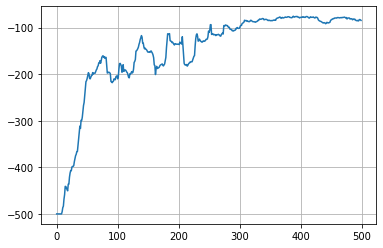

In [6]:
plt.plot(means)
plt.grid()
plt.show()

In [8]:
env = gym.make('Acrobot-v1')
for i in range(20):
    done = False
    state = env.reset()
    while not done:
        env.render()
        action = np.argmax(agent.Q_eval.advantage(np.expand_dims(state, axis=0))[0])
        n_state, reward, done, _ = env.step(action)
        state = n_state
env.close()

In [9]:
agent.save()